In [1]:
# # https://github.com/jupyterlab/jupyterlab/issues/6910
# # import os
# # import sys
# # sys.path.append(os.path.abspath('') + '/..')

# # from data import ImplicitData

# from flurs.data.entity import User, Item, Event
# from flurs.recommender import UserKNNRecommender
# import pandas as pd
# import numpy as np

# data = pd.read_csv("../datasets/ml1m_gte5.csv", sep='\t')
# user_col = 'UserID'
# item_col = 'ItemID'
# data.head()

# data2=data.copy()

# usermap = pd.Series(pd.unique( data[user_col] )).reset_index().set_index(0).to_dict()['index']
# itemmap = pd.Series(pd.unique( data[item_col] )).reset_index().set_index(0).to_dict()['index']
# # 3m 24.7s
# # def mapfun(x, unique=pd.unique( data[item_col] )):
# #     return np.where( unique == x )[0][0]
# # remaping user/item names so that they are ordered from 0 to number of users/items
# # Flurs need user/item IDs to be increasing order integers
# # data2[item_col]=data2[item_col].map(mapfun)
# # data2[user_col]=data2[user_col].map( lambda x: mapfun( x, unique=pd.unique( data[user_col] ) ) )

# data2[user_col]=data2[user_col].map(usermap)
# data2[item_col]=data2[item_col].map(itemmap)

# data2 = data2.iloc[:, :2].values

# # Initialize model
# knn_RS = UserKNNRecommender(k=5)
# knn_RS.initialize()

# # For each interaction - register user, register item, register event
# for u, i in data2[:1000]:
#     # print(u,i)
#     user = User(u)
#     knn_RS.register(user)

#     item = Item(i)
#     knn_RS.register(item)

#     event = Event(user, item)
#     knn_RS.update(event)

# knn_RS.users[0]['known_items']

# for i in knn_RS.users[0]['known_items']:
#     print(i)

# knn_RS.recommend(User(0), np.unique( data2[:1000, 1] ) ) # np.unique( data2[:, 1] ).reshape(1,-1)
# => (sorted candidates, scores)

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
# from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from flurs.recommender import BPRMFRecommender, SketchRecommender
from eval_implicit import EvaluateHoldoutsFlurs# EvaluateHoldouts, EvaluateAndStore,  # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

# from flurs.data.entity import User, Item, Event

import pandas as pd
import numpy as np

from datetime import datetime
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [2]:
# importa dataset 'books playlists'
data = pd.read_csv('output/amazonbooks_dump/3rd_sampled_amazon_books.csv')
dataset_name = 'Amazon_Books'
user_col = 'user_id'
item_col = 'item_id'
# data.sort_values(by='timestamp', inplace=True)

In [3]:
buckets = joblib.load('output/amazonbooks_dump/3rd_sample_buckets.joblib')
holdouts = joblib.load('output/amazonbooks_dump/3rd_sample_holdouts.joblib')

In [ ]:
# # https://flurs.readthedocs.io/en/latest/reference.html#evaluation-utilities
# import time

# class EvaluateHoldouts_Flurs():
#     def __init__(self, model, buckets, holdouts, data, user_col, item_col):
#         self.model = model
#         self.buckets = buckets
#         self.holdouts = holdouts
#         self.usermap = pd.Series(pd.unique( data[user_col] )).reset_index().set_index(0).to_dict()['index']
#         self.itemmap = pd.Series(pd.unique( data[item_col] )).reset_index().set_index(0).to_dict()['index']
#         self.max_users = data[user_col].nunique()
#         self.max_items = data[item_col].nunique()
#         self.metrics = ["Recall@N"]
#         self.IncrementalTraining_time_record = {}
#         self.EvaluateHoldouts_time_record = {}

#     def train_evaluate(self, N_recommendations=20, exclude_known_items:bool=True):
#         '''
#         Incremental training of recommendation model.
#         '''
#         # model_checkpoints = []
#         self.results_matrix = np.zeros( shape=( len( self.holdouts ), len( self.holdouts ) ) )
#         # metric = self.metrics[0]
#         self.N_recommendations = N_recommendations
#         self.exclude_known_items = exclude_known_items
#         # Initialize model
#         # model = UserKNNRecommender(k=5) # model
#         self.model.initialize()
#         print('register users')
#         s = time.time()
#         for u in range(0, self.max_users):
#             if not ((u*100)/self.max_users)%5:
#                 print (((u*100)/self.max_users),'%')
#             self.model.register(User(u))
#         f = time.time()
#         print( f-s, 'register users time' )
#         print('register items')
#         s = time.time()
#         for i in range(0, self.max_items):
#             if not ((i*100)/self.max_items)%5:
#                 print (((i*100)/self.max_items),'%')
#             self.model.register(Item(i))
#         f = time.time()
#         print( f-s, 'register items time' )
#         self.max_item_ID = 0
#         self.cold_start_buckets = len( self.buckets ) - len( self.holdouts ) 
#         # for each bucket, perform incremental training, evaluate model state against all holdouts
#         for b, bucket in enumerate(self.buckets):
#             print(f'Training: bucket {b}')
#             incrtrain_time = []
#             for i in range(bucket.size):
#                 if not ( (i*100)/bucket.size ) % 5:
#                     print(( (i*100)/bucket.size ), '%')
#                 uid,iid = bucket.GetTuple(i)
#                 s = time.time()
#                 u_flurs, i_flurs = self.usermap[uid], self.itemmap[iid]
#                 self.max_item_ID = max(self.max_item_ID, i_flurs)
#                 # For each interaction - register user, register item, register event
#                 user = User(u_flurs)
#                 item = Item(i_flurs)
#                 event = Event(user, item)
# #                 self.model.register(user)
# #                 self.model.register(item)
#                 self.model.update(event)
#                 f = time.time()
#                 incrtrain_time.append(f-s)        

#             self.IncrementalTraining_time_record[f'bucket_{b}'] = {
#                 'size':bucket.size,
#                 'train time vector':incrtrain_time,
#                 'avg train time':np.mean(incrtrain_time),
#                 'total train time':np.sum(incrtrain_time)
#                 }            

#             if b >= self.cold_start_buckets:
#                 self._evaluate(n_bucket=b)

#     def _evaluate(self, n_bucket):
#         # after learning a bucket, evaluate model over every holdout     
#         evaluate_time = [] 
#         time_get_tuple = []
#         time_recommend = []
#         time_del_user_items = []
#         time_eval_point = []  
#         for i, hd in enumerate(self.holdouts):
#             print(f'Evaluating: model {n_bucket-self.cold_start_buckets} x holdout {i}')
#             start_evaluate_time = time.time()
#             results = {}
#             # for metric in self.metrics:
#             metric = self.metrics[0]
#             results[metric] = []
#             for hd_i in range(hd.size):
#                 if not ( (hd_i*100)/hd.size ) % 5:
#                     print(( (hd_i*100)/hd.size ), '%')
#                 # GetTuple
#                 s = time.time()
#                 uid, iid = hd.GetTuple(hd_i) # get external IDs
#                 u_flurs, i_flurs = self.usermap[uid], self.itemmap[iid]
#                 user = User(u_flurs)
#                 f = time.time()
#                 time_get_tuple.append(f - s)
#                 # recommend
#                 s = time.time()
#                 reclist = self.model.recommend(user, np.arange(self.max_item_ID+1) )[0]
#                 f = time.time()
#                 time_recommend.append(f - s)
#                 # get items seen by user up until bucket 'n_bucket'
#                 # delete seen items 
#                 s = time.time()
#                 user_items = self.buckets[n_bucket].GetUserItems(uid, internal=False) 
#                 for previous_b in range(n_bucket):
#                     user_items = np.concatenate((user_items, self.buckets[previous_b].GetUserItems(uid, internal=False)))
#                 user_items = [self.itemmap[i] for i in user_items]
#                 if self.exclude_known_items:
#                     reclist = np.delete(reclist, user_items)
#                 f = time.time()
#                 time_del_user_items.append(f - s)
#                 # get n recommendations
#                 n = self.N_recommendations
#                 if n == -1:
#                     n = len(reclist)
#                 reclist = reclist[:n]
#                 if len(reclist):
#                     s = time.time()
#                     results[metric].append(self.__EvalPoint(i_flurs, reclist))
#                     f = time.time()
#                     time_eval_point.append(f - s)
#                 else:
#                     print(uid, 'user not seen')
#             result = results[metric]
#             n_not_seen = hd.size - len(result) # if user was not seen, its not added to recall. May be needed to store difference.
#             if n_not_seen:
#                 print(f'recommendations not made for users in holdout {i} x bucket {n_bucket}: {n_not_seen}')
#             result = sum( result ) / len(result)
#             self.results_matrix[n_bucket-self.cold_start_buckets, i] = result
#             end_evaluate_time = time.time()
#             evaluate_time.append(end_evaluate_time - start_evaluate_time)
#             self.EvaluateHoldouts_time_record[f'model {n_bucket-self.cold_start_buckets} x holdout {i}'] = {
#                 'size': hd.size,
#                 'train time vector':evaluate_time,
#                 'avg model eval time':np.mean(evaluate_time),
#                 'total train time':np.sum(evaluate_time),
#                 'time_get_tuple': time_get_tuple,
#                 'time_recommend': time_recommend,
#                 'time_del_user_items': time_del_user_items,
#                 'time_eval_point': time_eval_point,
#             }

#     def __EvalPoint(self, item_id, reclist):
#         result = 0
#         if len(reclist) == 0:
#             return 0
#         for metric in self.metrics:
#             if metric == "Recall@N":
#                 result = int(item_id in reclist)
#         return result

In [10]:
data=data[ data['week'] == 1 ]# use sample

In [11]:
BPRMF = EvaluateHoldoutsFlurs(BPRMFRecommender(), [buckets[0]], [holdouts[0]], data, user_col, item_col)

In [12]:
%%time
# 26min 52s
# bem mais rápido registrar usuários e itens com BPRMF do que com KNN
BPRMF.Train_Evaluate(N_recommendations = 20, exclude_known_items = True)

register users
0.0 %
25.0 %
50.0 %
75.0 %
0.53216552734375 register users time
register items
0.0 %
20.0 %
40.0 %
60.0 %
80.0 %
117.84170174598694 register items time
Training: bucket 0
0.0 %
20.0 %
40.0 %
60.0 %
80.0 %
Evaluating: model 0 x holdout 0
0.0 %
20.0 %
40.0 %
60.0 %
80.0 %
CPU times: user 40min 40s, sys: 56min 52s, total: 1h 37min 33s
Wall time: 17min 32s


In [13]:
BPRMF.results_matrix

array([[0.0003104]])

In [12]:
df = pd.DataFrame(BPRMF.results_matrix)
# df.to_csv('output/amazonbooks_dump/3rd_sample_amazon_books month_bucket BPRMF results.csv', index=False)

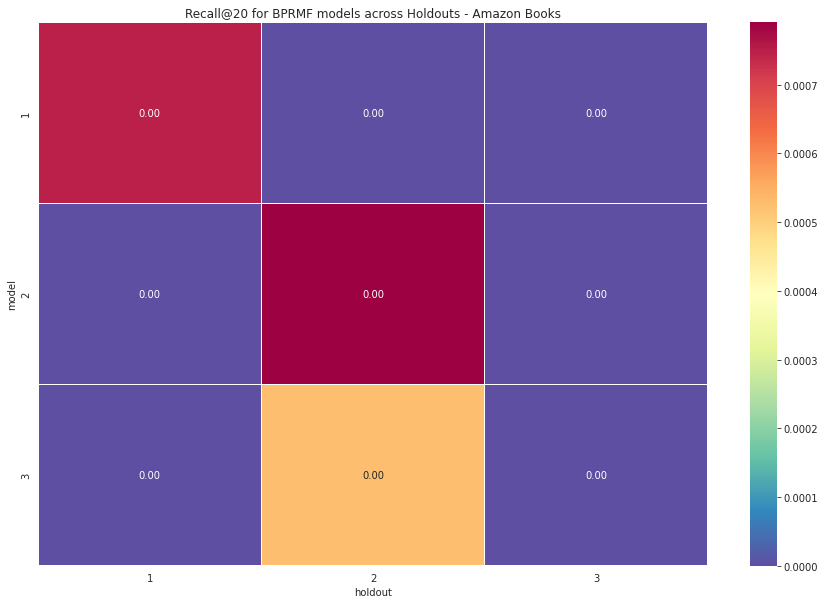

In [13]:
recall_heatmap(df,
    title='Recall@20 for BPRMF models across Holdouts - Amazon Books'),
#     filepath='images/heatmaps/amazonbooks_dump/3rd_sample_amazon_books month_bucket BPRMF heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [16]:
# joblib.dump(BPRMF.IncrementalTraining_time_record, 'output/amazonbooks_dump/3rd_sample_amazon_books month_bucket BPRMF training time.joblib')
# joblib.dump(BPRMF.EvaluateHoldouts_time_record, 'output/amazonbooks_dump/3rd_sample_amazon_books month_bucket BPRMF eval time.joblib')

['output/amazonbooks_dump/3rd_sample_amazon_books month_bucket BPRMF eval time.joblib']